# GEI723, Université de Sherbrooke, Nov. 2020
# Problème de classification de caractère manuscrits

Ce notebook est une adaptation de la classification par STDP de MNIST par Diehl & Cook, créé par I. Balafrej pour l'automne 2019, et adapté par A. El Ferdaoussi pour l'automne 2020.

L'article de Diehl & Cook est disponible ici: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

Ce code permet de tester le réseau entrainé. Il a été complété et adapté par 

* ETTAHI Yahya (CIP:etty2601)
* WAHBI Yasmine (CIP:wahy3501)
* YARGA Arnaud (CIP:yars2201)

Il s'articule suivant le plan suivant :

* Lecture des fichiers sauvegardés
* Importation des données
* Création du réseau de neurones
* Test
* Résultat

In [1]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\asus\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
INFO       Cache size for target "cython": 5770 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\asus\.cython\brian_extensions" directory. [brian2]


## 1- Lecture des fichiers sauvegardés
Proposé par YARGA Arnaud

In [2]:
import pickle
with open('weightfile', 'rb') as fp:
    weight_matrix = pickle.load(fp)
with open('labelfile', 'rb') as fp:
    labeled_neurons = pickle.load(fp)

## 2 - Importation des données

On télécharge l'ensemble de données MNIST directement dans le code. MNIST est disponible à https://www.openml.org/d/554

In [3]:
X_all, y_all = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None)

Pour le test nous utilisons 2000 données. Cependant le choix est fait après les 10000 premières images qui ont été utilisées pour l'entrainement et la validation.

In [5]:
start = 10000
nb_test_data = 2000
X_test = X_all[start:start+nb_test_data]
y_test = y_all[start:start+nb_test_data]

## 3- Création du réseau de neurones

On peut maintenant créer un réseau Brian2. Commençons par définir quelques paramètres.

In [6]:
# Fixons le seed aléatoire afin de pouvoir reproduire les résultats
np.random.seed(0)

# Horloge de Brian2
defaultclock.dt = 0.5 * units.ms

# Cible de génération de code pour Brian2
prefs.codegen.target = 'cython'

time_per_sample =   0.35 * units.second
resting_time = 0.15 * units.second

v_rest_e = -65. * units.mV 
v_rest_i = -60. * units.mV 

v_reset_e = -65. * units.mV
v_reset_i = -45. * units.mV

v_thresh_e = -52. * units.mV
v_thresh_i = -40. * units.mV

refrac_e = 5. * units.ms
refrac_i = 2. * units.ms

tc_theta = 1e7 * units.ms
theta_plus_e = 0.05 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms
tc_post_2_ee = 40 * units.ms

# Taux d'apprentissage
nu_ee_pre =  0.0001
nu_ee_post = 0.001

#Nombre des neurones excitateurs et inhibiteurs
nb_ex = 100
nb_inhi = nb_ex

#poids maximum
wmax = 10.0

Définissons l'entrée au réseau de neurones. L'entrée est un encodeur de type codage par fréquence. On utilise ici une variante des PoissonGroup de Brian2 comme mentionné dans la documentation https://brian2.readthedocs.io/en/latest/user/input.html#setting-rates-for-poisson-inputs

In [7]:
input_group = NeuronGroup(28*28, 'rates : Hz', threshold='rand()<rates*dt')

Définissons notre modèle de neurone ainsi que nos groupes de neurones.

In [8]:
neuron_model = '''
    dv/dt = ((v_rest_e - v) + (I_synE + I_synI) / nS) / tau  : volt (unless refractory)

    I_synE =  ge * nS * -v           : amp
    
    I_synI =  gi * nS * (d_I_synI-v) : amp
    
    dge/dt = -ge/(1.0*ms)            : 1
    
    dgi/dt = -gi/(2.0*ms)            : 1
    
    tau                              : second (constant, shared)
    
    d_I_synI                         : volt (constant, shared)
    
    dtheta/dt = -theta / (tc_theta)  : volt
    
    homeosthasy : boolean (shared) # Activer/désactiver l'homéosthasie
'''

excitatory_group = NeuronGroup(
    N=nb_ex, model=neuron_model, refractory=refrac_e, 
    threshold='v>(v_thresh_e- 20.0*mV+theta*int(homeosthasy))', reset='v=v_reset_e; theta += theta_plus_e', method='euler')
excitatory_group.tau = 100 * units.ms
excitatory_group.d_I_synI = -100. * units.mV
excitatory_group.homeosthasy = True

inhibitory_group = NeuronGroup(
    N=nb_inhi, model=neuron_model, refractory=refrac_i, 
    threshold='v>(v_thresh_i)', reset='v=v_reset_i', method='euler')
inhibitory_group.tau = 10 * units.ms
inhibitory_group.d_I_synI = -85. * mV

Et les synapses.

In [9]:
synapse_model = "w : 1"

stdp_synapse_model = '''
    w : 1

    plastic : boolean (shared) # Activer/désactiver la plasticité
    
    post2before : 1
    
    dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
    
    dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
    
    dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
'''

stdp_pre = '''
    ge_post += w
    
    pre = 5. * int(plastic)
    
    w = clip(w + nu_ee_pre * post1 * int(plastic), 0, wmax)
'''

    
stdp_post = '''
    post2before = post2
    
    w = clip(w + nu_ee_post * pre * post2before * int(plastic), 0, wmax)
    
    post1 = -5. * int(plastic)
    
    post2 = 5. * int(plastic)
'''


input_synapse = Synapses(input_group, excitatory_group, model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post)
input_synapse.connect(True) # Fully connected
input_synapse.plastic = False
input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]

e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=synapse_model, on_pre='ge_post += w')
e_i_synapse.connect(condition='i == j')
e_i_synapse.w = 'rand()*10.4'

i_e_synapse = Synapses(inhibitory_group, excitatory_group, model=synapse_model, on_pre='gi_post += w')
i_e_synapse.connect(condition='i != j')
i_e_synapse.w = '17.0'

Définissons un 'readout' pour notre réseau.

In [10]:
e_monitor = SpikeMonitor(excitatory_group, record=True)

Créons le réseau.

In [11]:
net = Network(input_group, excitatory_group, inhibitory_group, 
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

Visualisons les labels et les champs récepteurs

[[0 0 9 6 5 7 0 2 8 9]
 [2 0 2 4 9 3 2 3 3 6]
 [6 9 0 5 3 7 0 2 6 3]
 [6 2 0 4 3 0 8 6 0 3]
 [7 9 0 3 1 3 0 4 1 6]
 [0 0 6 0 6 1 0 8 3 6]
 [2 7 0 8 8 0 3 8 8 6]
 [0 0 8 3 9 4 5 2 2 0]
 [3 8 7 6 0 3 4 9 0 0]
 [0 4 2 2 0 0 2 7 3 8]]


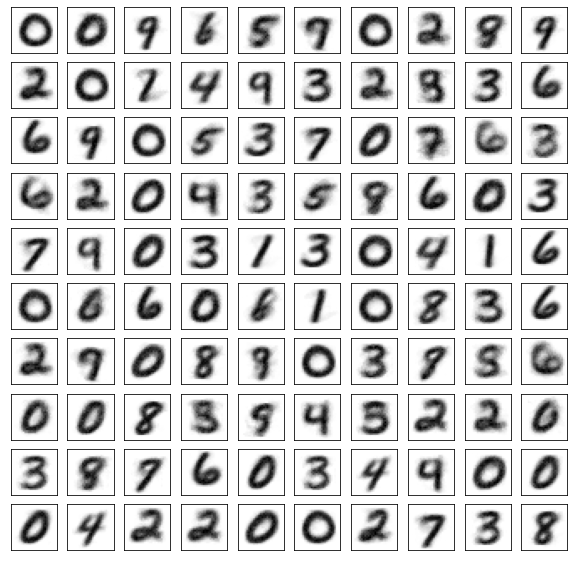

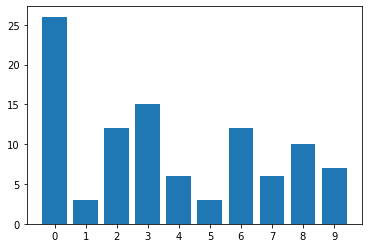

In [12]:
print(labeled_neurons.reshape(10,10))

weight_matrix_T = weight_matrix.T
plt.figure(figsize=(10,10))
for u in range(10):
    for uu in range(10):
        ax = plt.subplot2grid((10,10),(u,uu))
        ax.imshow(weight_matrix_T[u*10+uu].reshape(28, 28), cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
plt.show()

b = np.bincount(labeled_neurons)
bar(range(len(b)),b)
xticks(range(len(b)))
show()

## 4- Test
Testons à présent le réseau sur les 2000 données de test

In [14]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False
old_spike_counts = np.zeros(len(excitatory_group))

num_correct_output = 0
confusion_matrix = np.zeros(100).reshape(10,10)
start_time = time.time()
for i, (sample, label) in enumerate(zip(X_test, y_test)):
    # Afficher régulièrement l'état d'avancement
    if (i % 20) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))
    
    # Configurer le taux d'entrée
    # ATTENTION, vous pouvez utiliser un autre type d'encodage
    input_group.rates = (sample / 4) * units.Hz
    
    # Simuler le réseau
    net.run(time_per_sample)
    
    # Calculer le nombre de décharges pour l'échantillon
    current_spike_count = e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)
    
    # Prédire la classe de l'échantillon
    output_label = labeled_neurons[np.argmax(current_spike_count)]
    
    # Si la prédiction est correcte
    if output_label == int(label):
        num_correct_output += 1
    confusion_matrix[int(label)][output_label] +=1
        
    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)

duration = (time.time() - start_time)/60
print("TESTING --- %s minutes ---" % duration)
print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))

Running sample 0 out of 2000
Running sample 20 out of 2000
Running sample 40 out of 2000
Running sample 60 out of 2000
Running sample 80 out of 2000
Running sample 100 out of 2000
Running sample 120 out of 2000
Running sample 140 out of 2000
Running sample 160 out of 2000
Running sample 180 out of 2000
Running sample 200 out of 2000
Running sample 220 out of 2000
Running sample 240 out of 2000
Running sample 260 out of 2000
Running sample 280 out of 2000
Running sample 300 out of 2000
Running sample 320 out of 2000
Running sample 340 out of 2000
Running sample 360 out of 2000
Running sample 380 out of 2000
Running sample 400 out of 2000
Running sample 420 out of 2000
Running sample 440 out of 2000
Running sample 460 out of 2000
Running sample 480 out of 2000
Running sample 500 out of 2000
Running sample 520 out of 2000
Running sample 540 out of 2000
Running sample 560 out of 2000
Running sample 580 out of 2000
Running sample 600 out of 2000
Running sample 620 out of 2000
Running sample

Observons la carte d'activation des neurones

Par ETTAHI Yahya

113382


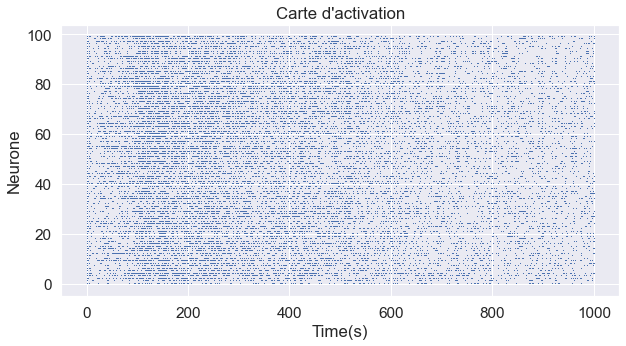

In [19]:
print(e_monitor.num_spikes)
plt.figure(figsize=(10,5))
plt.title("Carte d'activation")
plt.plot(e_monitor.t/second, e_monitor.i, ',')
plt.xlabel('Time(s)')
plt.ylabel('Neurone')
plt.show()

## Résulats

Observons la matrice de confusion. En abcisse on a les classes prédites et en ordonnées les classes réelles. Par exemple dans la première case (bas, gauche) on a le nombre de données de classe '9' ayant été classées par le réseau comme '0'

Par YARGA Arnaud

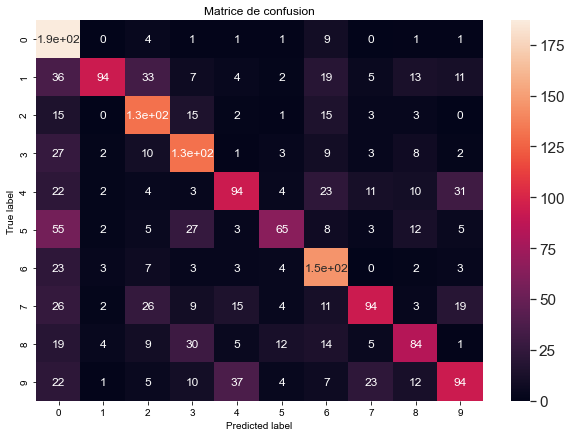

In [17]:
import seaborn as sn
import pandas as pd

#print(confusion_matrix)
array = confusion_matrix

df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(10,7))
plt.title("Matrice de confusion")
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Normalisons notre matrice de confusion afin d'observer les pourcentages de réussite pour chaque classe

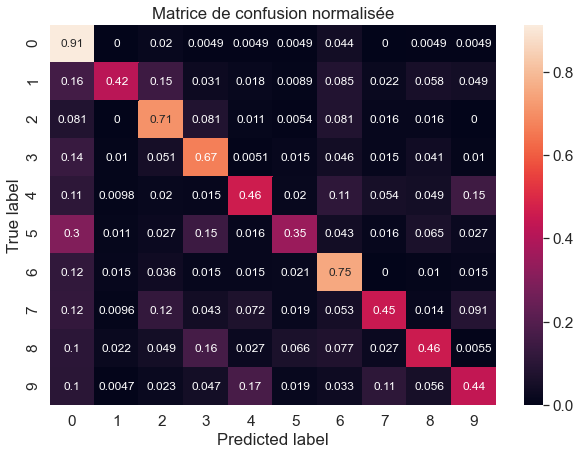

In [18]:
confusion_matrix_norm = np.copy(confusion_matrix)
sumLig = np.sum(confusion_matrix, axis=1)
ligFactors = 1/sumLig
for i in range(10):
    confusion_matrix_norm[i,:] *= ligFactors[i]
    
array = confusion_matrix_norm
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(10,7))
plt.title("Matrice de confusion normalisée")
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()